In [66]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Geometry import Point3D
import numpy as np
import matplotlib.pyplot as plt

In [67]:
def read_sdf(file_path):
    mol = Chem.SDMolSupplier(file_path, removeHs=False, strictParsing=False)[0]
    return mol

def calc_energy(mol):
    props = AllChem.MMFFGetMoleculeProperties(mol)
    ff = AllChem.MMFFGetMoleculeForceField(mol, props)
    return ff.CalcEnergy()

In [68]:
# Read molecule in from sdf file
water_mol = Chem.SDMolSupplier("molecules/water_3d.sdf", removeHs=False, strictParsing=False)[0]

# Check atom positions
conf = water_mol.GetConformer()
for i, atom in enumerate(water_mol.GetAtoms()):
    pos = conf.GetAtomPosition(i)
    print(i, pos.x, pos.y, pos.z)

0 -0.0211 -0.002 0.0
1 0.8345 0.4519 0.0
2 1.4769 -0.273 0.0


[23:00:32] CTAB version string invalid at line 4


In [138]:
# Atom indices in water_mol
H1_idx = 0
O_idx = 1
H2_idx = 2

# Get positions of all atoms as np arrays
conf = water_mol.GetConformer()
o_pos = conf.GetAtomPosition(O_idx)
o_pos_arr = np.array([o_pos.x, o_pos.y, o_pos.z])
h1_pos = conf.GetAtomPosition(H1_idx)
h1_pos_arr = np.array([h1_pos.x, h1_pos.y, h1_pos.z])
h2_pos = conf.GetAtomPosition(H2_idx)
h2_pos_arr = np.array([h2_pos.x, h2_pos.y, h2_pos.z])

# OH1 bond vector 
oh1_vector = h1_pos_arr - o_pos_arr
oh1_length = np.linalg.norm(oh1_vector)
oh1_unit_vector = oh1_vector / oh1_length

# OH2 bond vector
oh2_vector = h2_pos_arr - o_pos_arr
oh2_length = np.linalg.norm(oh2_vector)

# Original angle between OH1 and OH2 (used for debugging)
orig_angle = np.arccos(np.dot(oh1_vector, oh2_vector) / (oh1_length * oh2_length))

# Create rotation axis to rotate OH1 vector starting from OH2 vector
rotation_axis = np.cross(oh1_vector, oh2_vector)
rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)

In [70]:
# Create range of bond lengths (in Angstroms)
bond_lengths = np.arange(0.7, 1.5, 0.01) 
bond_energies = []

# For each bond length, create new conformer and calculate energy
for length in bond_lengths:
    
    # Get new H1 position by scaling OH1 vector to new length
    new_oh1_vector = oh1_unit_vector * length + o_pos_arr
    new_h1_pos = Point3D(
        new_oh1_vector[0],
        new_oh1_vector[1],
        new_oh1_vector[2]
    )
    
    # Set new H position
    conf.SetAtomPosition(H1_idx, new_h1_pos)
    
    # Calculate energy
    energy = calc_energy(water_mol)
    bond_energies.append(energy)

# Reset H1 atom position
conf.SetAtomPosition(H1_idx, h1_pos)


In [139]:
# Create range of angles (in radians)
angles = np.arange(1.4, 2.4, 0.01) 
angle_energies = []

# For each angle, rotate H1 and calculate energy
for angle in angles:
    
    # Rotate OH1 vector around rotation axis to create new H1 position starting from OH2 vector
    h1_rot = oh2_vector * np.cos(-angle) + np.cross(rotation_axis, oh2_vector) * np.sin(-angle) + rotation_axis * np.dot(rotation_axis, oh2_vector) * (1 - np.cos(-angle))
    h1_rot = ((h1_rot / np.linalg.norm(h1_rot)) * oh1_length) + np.array([o_pos.x, o_pos.y, o_pos.z])

    # Calculate new H1 position
    new_h1_pos = Point3D(
        h1_rot[0],
        h1_rot[1],
        h1_rot[2]
    )
    
    # Set new H1 position
    conf.SetAtomPosition(H1_idx, new_h1_pos)
    
    # Calculate energy
    energy = calc_energy(water_mol)
    angle_energies.append(energy)

# Reset H1 position
conf.SetAtomPosition(H1_idx, h1_pos)


[-0.60513943 -0.75622936  0.        ]
0.9685435302556101


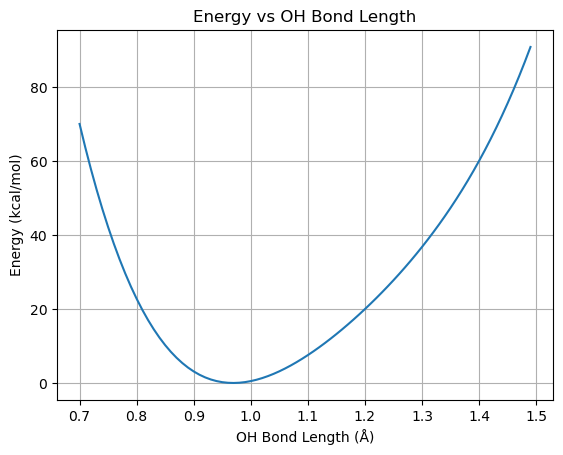

In [71]:
plt.plot(bond_lengths, bond_energies)
plt.xlabel('OH Bond Length (Å)')
plt.ylabel('Energy (kcal/mol)')
plt.title('Energy vs OH Bond Length')
plt.grid(True)
plt.savefig('ref_H2O_bond_energy.png')
plt.show()

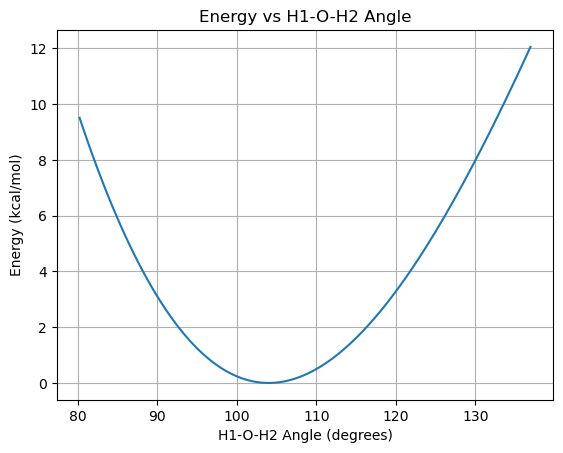

In [72]:
plt.plot(np.rad2deg(angles), angle_energies)
plt.xlabel('H1-O-H2 Angle (degrees)')
plt.ylabel('Energy (kcal/mol)')
plt.title('Energy vs H1-O-H2 Angle')
plt.grid(True)
plt.savefig('ref_H2O_angle_energy.png')
plt.show()

In [147]:
# Read bond_energies from file
cpp_bond_energies = []
with open('data/bond_energies.txt', 'r') as f:
    for line in f:
        cpp_bond_energies.append(float(line.strip()))

cpp_angle_energies = []
with open('data/angle_energies.txt', 'r') as f:
    for line in f:
        cpp_angle_energies.append(float(line.strip()))


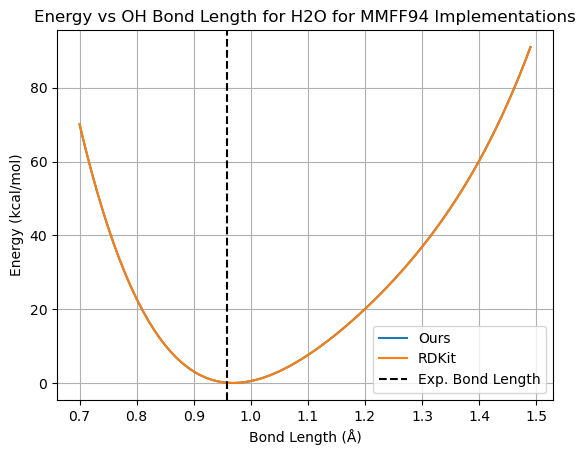

In [150]:
plt.plot(bond_lengths, cpp_bond_energies, label='Ours')
plt.plot(bond_lengths, bond_energies, label='RDKit')
plt.axvline(x=0.9578, linestyle='--', color='black', label='Exp. Bond Length')
plt.xlabel('Bond Length (Å)')
plt.ylabel('Energy (kcal/mol)')
plt.title('Energy vs OH Bond Length for H2O for MMFF94 Implementations')
plt.grid(True)
plt.legend(['Ours', 'RDKit', 'Exp. Bond Length'])
plt.savefig('ff_comparison_bond.png')
plt.show()

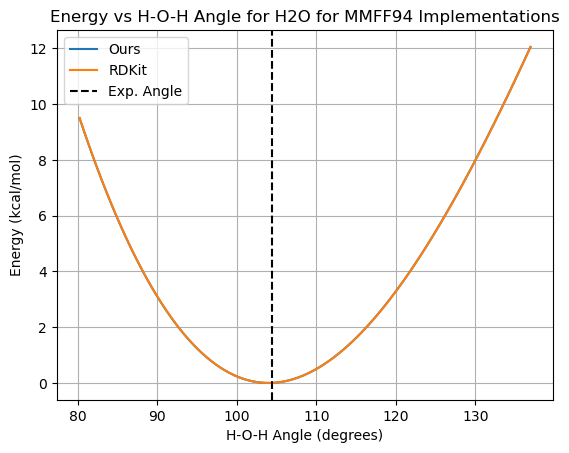

In [151]:
plt.plot(np.rad2deg(angles), cpp_angle_energies, label='Ours')
plt.plot(np.rad2deg(angles), angle_energies, label='RDKit')
plt.axvline(x=104.478, linestyle='--', color='black', label='Exp. Angle')
plt.xlabel('H-O-H Angle (degrees)')
plt.ylabel('Energy (kcal/mol)')
plt.title('Energy vs H-O-H Angle for H2O for MMFF94 Implementations')
plt.grid(True)
plt.legend(['Ours', 'RDKit', 'Exp. Angle'])
plt.savefig('ff_comparison_angle.png')
plt.show()